In [1]:
# Author Dmitry Ermilov
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imageio
from skimage import color

def compress(image, k=2):
    n, m = image.shape[:2]
    n_k = n // k
    m_k = m // k
    new_image = np.zeros_like(image)[:n_k, :m_k]
    for i in range(n_k):
        for j in range(m_k):
            new_image[i, j] = np.mean(image[k*i:k*(i+1), k*j:k*(j+1)].reshape(k**2, -1), axis=0)
    return new_image

In [2]:
imgL = imageio.imread("photo_l.jpg")
imgR = imageio.imread("photo_r.jpg")
imgL.shape

(2059, 3527, 3)

(686, 1175, 3)

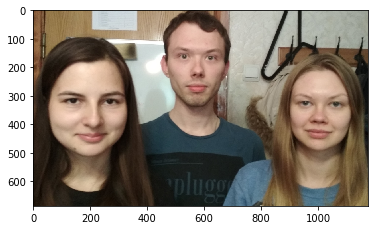

In [3]:
imgL_compress = compress(imgL[:2058, :3525], 3)
imgR_compress = compress(imgR[:2058, :3525], 3)
plt.imshow(imgL_compress)
imgL_compress.shape

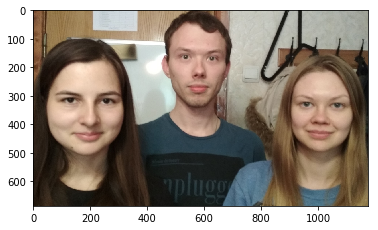

In [4]:
plt.imshow(imgR_compress)

In [5]:
plt.imsave("photo_l3.jpg", imgL_compress, format="jpg")
plt.imsave("photo_r3.jpg", imgR_compress, format="jpg")
#  -resize 440 256

In [6]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching photo_l3.jpg photo_r3.jpg -nt 1 -out photo3_output_lr.txt

Killed


In [ ]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching photo_r3.jpg photo_l3.jpg -nt 1 -out photo3_output_rl.txt

In [18]:
# plt.imsave("photo_l2.jpg", compress(imgL_compress), format="jpg")
# plt.imsave("photo_r2.jpg", compress(imgR_compress), format="jpg")

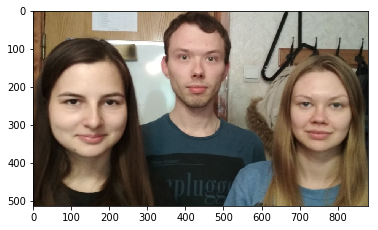

In [3]:
imgL = imageio.imread("photo_ll.jpg")#[::2, ::2, :]
imgR = imageio.imread("photo_rr.jpg")#[::2, ::2, :]
disparity_lr = np.int32(np.loadtxt("photo_output_lr.txt")[:, :4])# // 2
disparity_rl = np.int32(np.loadtxt("photo_output_rl.txt")[:, :4])# // 2
imgL_hsv = matplotlib.colors.rgb_to_hsv(imgL)
imgR_hsv = matplotlib.colors.rgb_to_hsv(imgR)

plt.imshow(imgL)

In [4]:
def findRectengular(image_shape, disp, sh):
    l2, l1, r2, r1 = disp
    N, M = image_shape
    sha = np.array([[-l1+sh, l1+sh-N, -l2+sh, l2+sh-M], 
                    [-r1+sh, r1+sh-N, -r2+sh, r2+sh-M], 
                    [0,      0,       0,      0      ]], np.int32).max(axis=0)
    return l1-sh+sha[0], l1+sh-sha[1], l2-sh+sha[2], l2+sh-sha[3], \
           r1-sh+sha[0], r1+sh-sha[1], r2-sh+sha[2], r2+sh-sha[3]  

def correctDisparity(imageL, imageR, disp, sh, sh_it):
#     print("In", disp)
    l2, l1, r2, r1 = disp
    N, M = imageL.shape[:2]
    d_min = 1000
    r10 = np.max((r1 - sh_it, 0))
    r1N = np.min((r1 + sh_it, N))
    r20 = np.max((r2 - sh_it, 0))
#     print(r2, M)
    r2M = np.min((r2 + sh_it, M))
#     print(r2 + sh_it)
#     p_min = None
    
    for p1 in range(r10, r1N):
        for p2 in range(r20, r2M):
            i10, i1N, i20, i2M, j10, j1N, j20, j2M = findRectengular(imageL.shape[:2], (l2, l1, p2, p1), sh)
            if i1N - i10 == 0  or i2M - i20 == 0:
#                 print("Continue")
                continue
            imgL_local = imageL[i10:i1N, i20:i2M]
            imgR_local = imageR[j10:j1N, j20:j2M]
            d_local = np.abs(imgL_local - imgR_local).mean()
#             print(d_min, d_local, p_min)
            if d_local < d_min:
                d_min = d_local
                p_min = i10, i1N, i20, i2M, j10, j1N, j20, j2M
#     print("Out", r10, r1N, r20, r2M, sh_it)
    return p_min, d_min

In [5]:
threshold = 2 #0.5
sh_it = 4
shift_list = [4, 3, 2, 1]

disp_rl = []
diff = np.empty(disparity_rl.shape[0])
disp = np.empty((disparity_rl.shape[0], 8), np.int32)
used_indices = np.zeros(disparity_rl.shape[0], dtype=np.bool_)
print("Right to Left")
for sh in shift_list:
    for i, disparity_local in enumerate(disparity_rl):
        disp[i], diff[i] = correctDisparity(imgR_hsv, imgL_hsv, disparity_local, sh, sh_it)
    indices_local = diff < threshold
    indices_local[used_indices] = False
    disp_rl.append(np.array(disp[indices_local]))
    used_indices[indices_local] = True
disp_rl = np.vstack(disp_rl)
    
disp_lr = []
diff = np.empty(disparity_lr.shape[0])
disp = np.empty((disparity_lr.shape[0], 8), np.int32)
used_indices = np.zeros(disparity_lr.shape[0], dtype=np.bool_)
print("Left to Right")
for sh in shift_list:
    for i, disparity_local in enumerate(disparity_lr):
        disp[i], diff[i] = correctDisparity(imgL_hsv, imgR_hsv, disparity_local, sh, sh_it)
    indices_local = diff < threshold
    indices_local[used_indices] = False
    disp_lr.append(np.array(disp[indices_local]))
    used_indices[indices_local] = True
disp_lr = np.vstack(disp_lr)

Right to Left
Left to Right


In [6]:
newR =np.zeros_like(imgR)
for disp_local in disp_rl:
    i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local
    newR[i10:i1N, i20:i2M] = imgL[j10:j1N, j20:j2M]

for disp_local in disp_lr:
    i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local
    newR[j10:j1N, j20:j2M] = imgL[i10:i1N, i20:i2M]

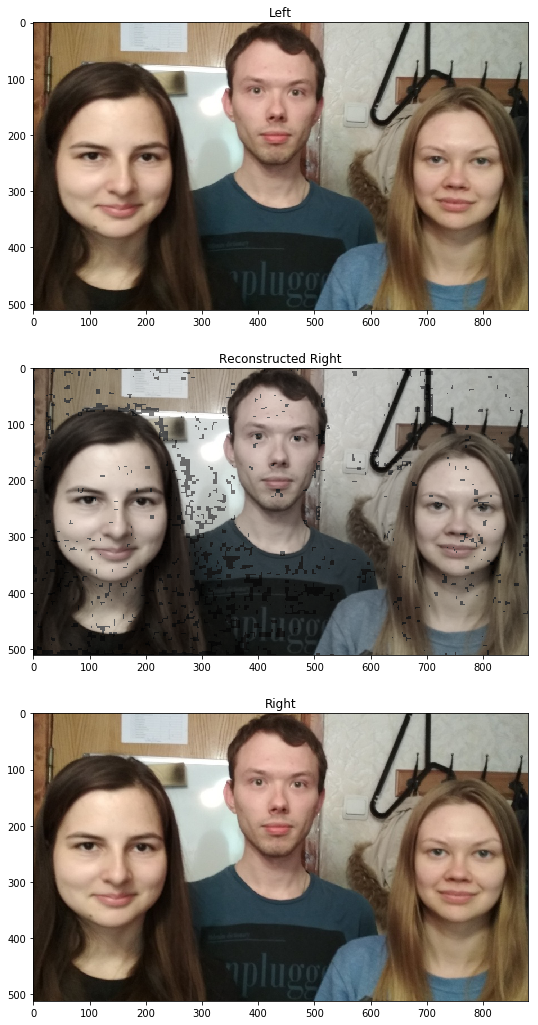

In [7]:
plt.figure(figsize=(10, 18))
plt.subplot(311)
plt.title("Left")
plt.imshow(imgL)
plt.subplot(312)
plt.title("Reconstructed Right")
plt.imshow(color.rgb2gray(imgR), cmap="gray")
plt.imshow(newR, alpha=0.5)
plt.subplot(313)
plt.title("Right")
plt.imshow(imgR)
plt.show()

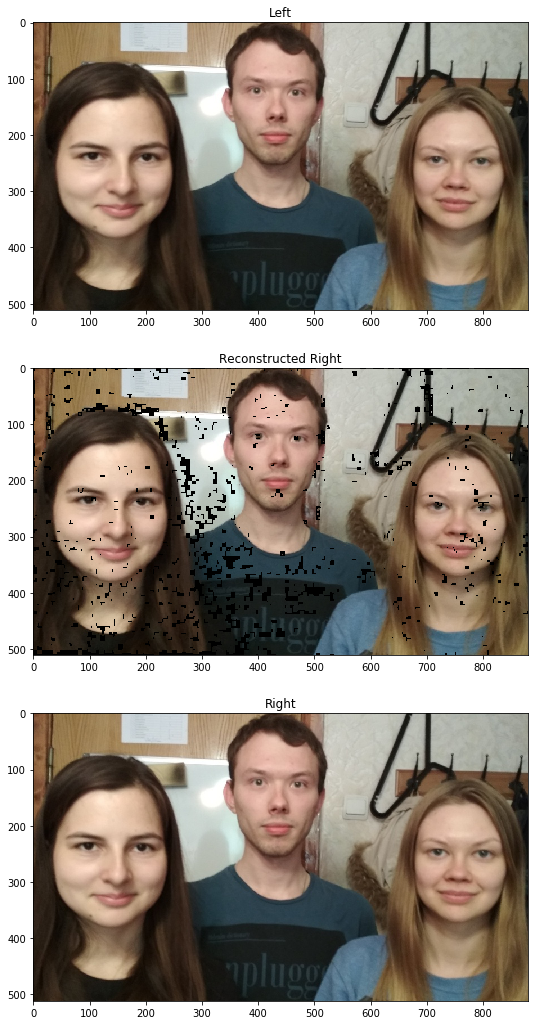

In [8]:
plt.figure(figsize=(10, 18))
plt.subplot(311)
plt.title("Left")
plt.imshow(imgL)
plt.subplot(312)
plt.title("Reconstructed Right")
plt.imshow(newR, alpha=1)
plt.subplot(313)
plt.title("Right")
plt.imshow(imgR)
plt.show()

In [9]:
def indices_to_disp_matrix(image_shape, disp_rl, disp_lr):
    matrix_1 = np.zeros(image_shape)
    matrix_2 = np.zeros(image_shape)
    for disp_local in disp_rl:
        i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local 
        matrix_1[i10:i1N, i20:i2M] = j10 - i10
        matrix_2[i10:i1N, i20:i2M] = j20 - i20
    for disp_local in disp_lr:
        i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local
        matrix_1[j10:j1N, j20:j2M] = i10 - j10
        matrix_2[j10:j1N, j20:j2M] = i20 - j20
    return matrix_1, matrix_2

m_h, m_v = indices_to_disp_matrix(imgR.shape[:2], disp_rl, disp_lr)
np.savetxt('photo_horisontal.txt', m_h, fmt='%d')
np.savetxt('photo_vertical.txt', m_v, fmt='%d')